<a href="https://colab.research.google.com/github/itay601/AVL-tree/blob/main/DDP_mnist_manualy_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu

Epoch 1/5:
Epoch 1 Train - Loss: 0.2960, Accuracy: 0.9080, F1 Score: 0.9076,Gradient : 0.004344432115613017 , Time: 52.40s
Epoch 1 Eval - Loss: 0.0871, Accuracy: 0.9730, F1 Score: 0.9728 , Time: 3.92s
Epoch [1/5] completed.

Epoch 2/5:
Epoch 2 Train - Loss: 0.0909, Accuracy: 0.9728, F1 Score: 0.9726,Gradient : 0.006100230512674898 , Time: 43.97s
Epoch 2 Eval - Loss: 0.0633, Accuracy: 0.9811, F1 Score: 0.9810 , Time: 4.00s
Epoch [2/5] completed.

Epoch 3/5:
Epoch 3 Train - Loss: 0.0655, Accuracy: 0.9797, F1 Score: 0.9795,Gradient : 0.009455855039414018 , Time: 42.96s
Epoch 3 Eval - Loss: 0.0499, Accuracy: 0.9849, F1 Score: 0.9848 , Time: 3.67s
Epoch [3/5] completed.

Epoch 4/5:
Epoch 4 Train - Loss: 0.0518, Accuracy: 0.9840, F1 Score: 0.9839,Gradient : 0.0025666697474662215 , Time: 43.31s
Epoch 4 Eval - Loss: 0.0562, Accuracy: 0.9829, F1 Score: 0.9829 , Time: 3.47s
Epoch [4/5] completed.

Epoch 5/5:
Epoch 5 Train - Loss: 0.0420, Accuracy: 0.9872, F1 Score: 0.9871,Grad

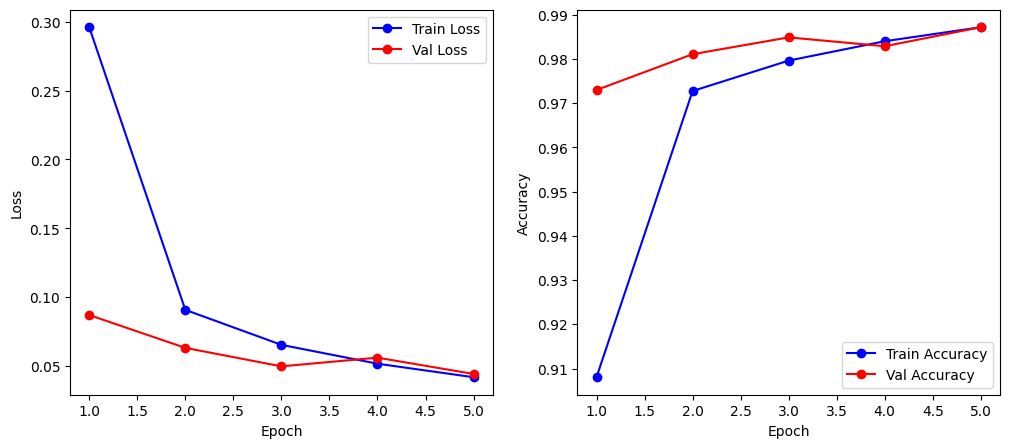

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import time
import numpy as np

# Load datasets
def load_data(batch_size):
    train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
    test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Define the CNN model
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def calculate_gradients(model):
    gradients = []
    for param in model.parameters():
        if param.grad is not None:
            grad = param.grad.data
            gradients.append(grad.abs().mean().item())
    return gradients


# Training loop
def train_model(model, device, train_loader, optimizer, loss_fn, epoch):
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []
    epoch_gradients = []


    start_time = time.time()
    for data in train_loader:
        X, y = data
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = output.argmax(dim=1, keepdim=True).squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
         # Calculate and store gradients
        gradients = calculate_gradients(model)
        epoch_gradients.append(np.mean(gradients))  # Store mean gradient magnitude for monitoring


    train_loss /= len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='macro')

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1} Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f},Gradient : {epoch_gradients[epoch]} , Time: {elapsed_time:.2f}s")

    return train_loss, train_acc, train_f1

# Evaluation loop
def evaluate_model(model, device, test_loader, loss_fn, epoch):
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    start_time = time.time()
    with torch.no_grad():
        for data in test_loader:
            X, y = data
            X, y = X.to(device), y.to(device)

            output = model(X)
            loss = loss_fn(output, y)
            val_loss += loss.item()

            preds = output.argmax(dim=1, keepdim=True).squeeze()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    val_loss /= len(test_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1} Eval - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f} , Time: {elapsed_time:.2f}s")

    return val_loss, val_acc, val_f1

# Plotting function
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Main function to run the training and evaluation
def main():
    batch_size = 64
    learning_rate = 0.001
    EPOCHS = 5

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_loader, test_loader = load_data(batch_size)
    model = NetCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_f1s = []
    val_f1s = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}:")

        # Training
        train_loss, train_acc, train_f1 = train_model(model, device, train_loader, optimizer, loss_fn, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)

        # Evaluation
        val_loss, val_acc, val_f1 = evaluate_model(model, device, test_loader, loss_fn, epoch)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        print(f"Epoch [{epoch+1}/{EPOCHS}] completed.")

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

if __name__ == "__main__":
    main()
